In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Читаем данные 

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_log_error

# Датасеты 
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
sample_sub = pd.read_csv("../data/sample_submission.csv")

train.shape, test.shape, sample_sub.shape
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


Базовая визализаация 

<Axes: xlabel='SalePrice', ylabel='Count'>

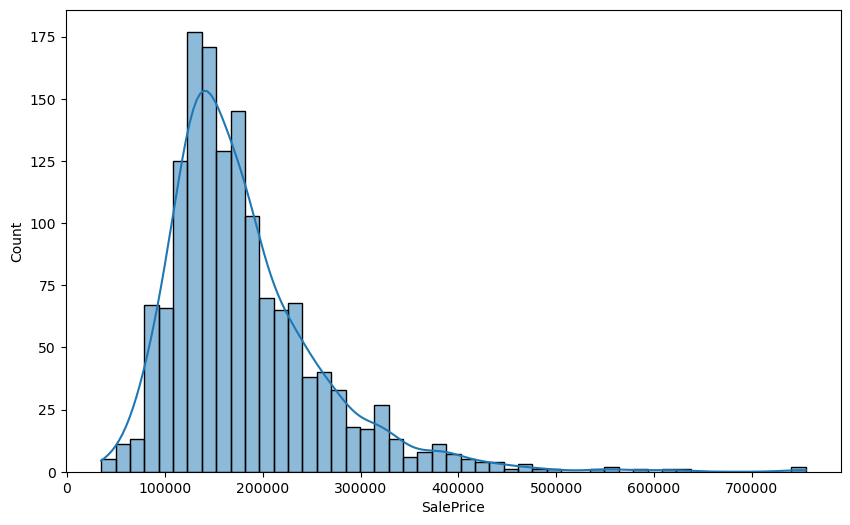

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(train['SalePrice'], kde=True)


<Axes: ylabel='SalePrice'>

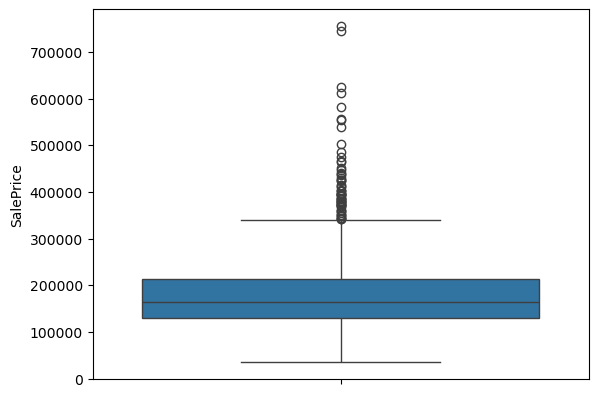

In [8]:
sns.boxplot(train['SalePrice'])

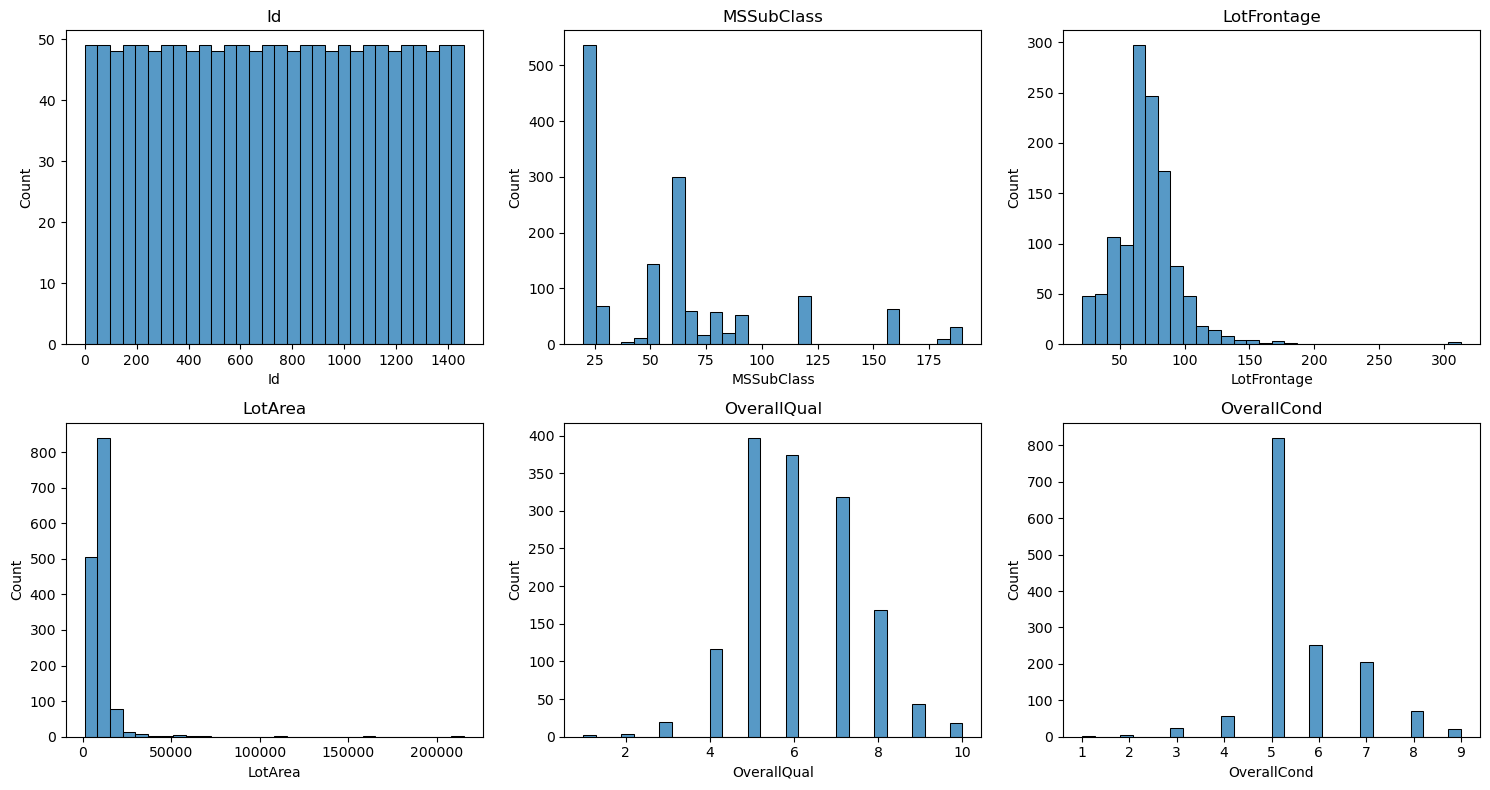

In [9]:
num_cols = train.select_dtypes(include=[np.number]).drop(columns=["SalePrice"]).columns
fig, axes = plt.subplots(2, 3, figsize=(15,8))
for col, ax in zip(num_cols[:6], axes.flatten()):
    sns.histplot(train[col].dropna(), bins=30, ax=ax, kde=False)
    ax.set_title(col)
plt.tight_layout()
plt.show()

Числовые признаки 

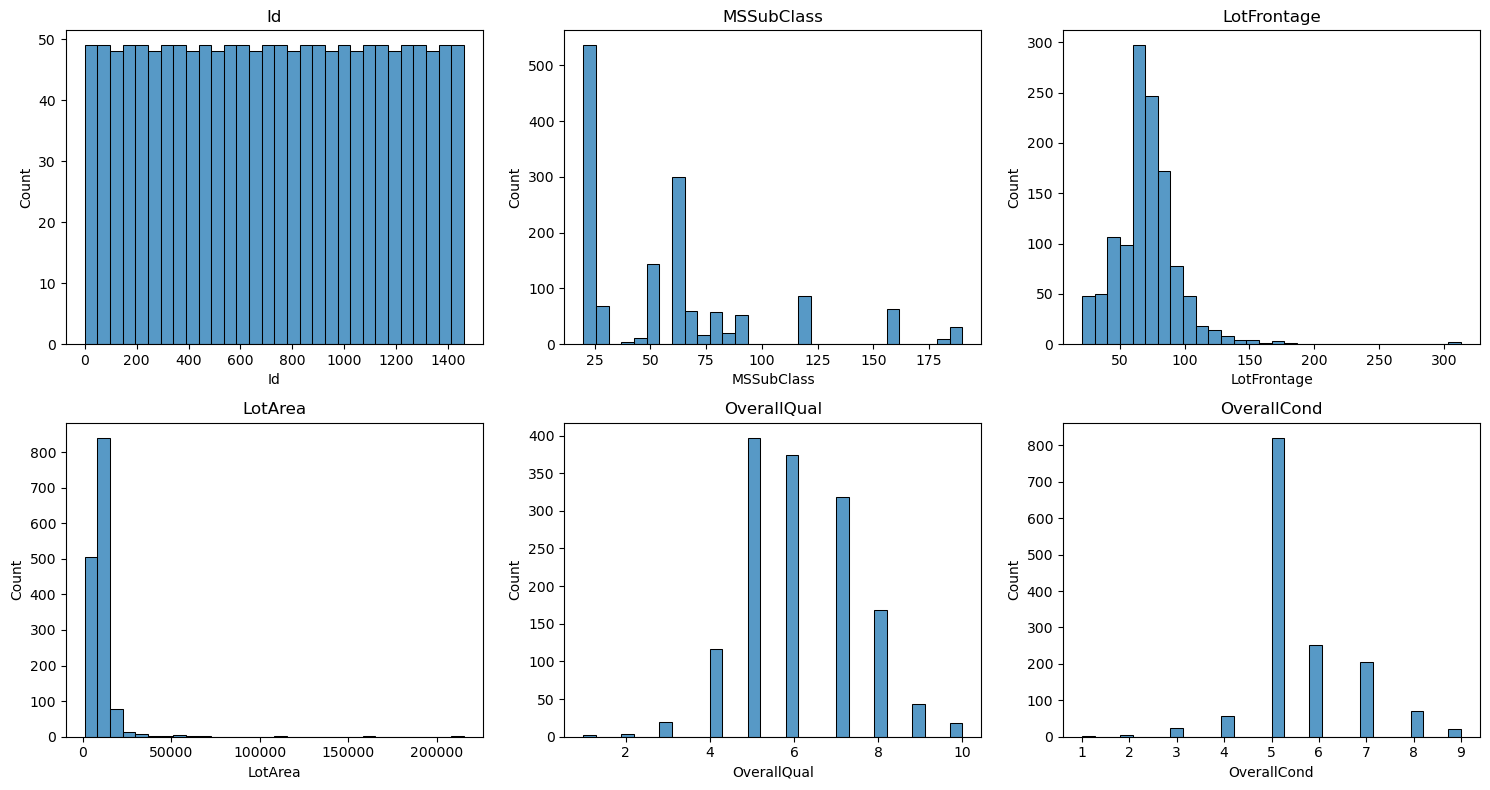

In [12]:
num_cols = train.select_dtypes(include=[np.number]).drop(columns=["SalePrice"]).columns
fig, axes = plt.subplots(2, 3, figsize=(15,8))
for col, ax in zip(num_cols[:6], axes.flatten()):
    sns.histplot(train[col].dropna(), bins=30, ax=ax, kde=False)
    ax.set_title(col)
plt.tight_layout()
plt.show()

Категоральные признаки 

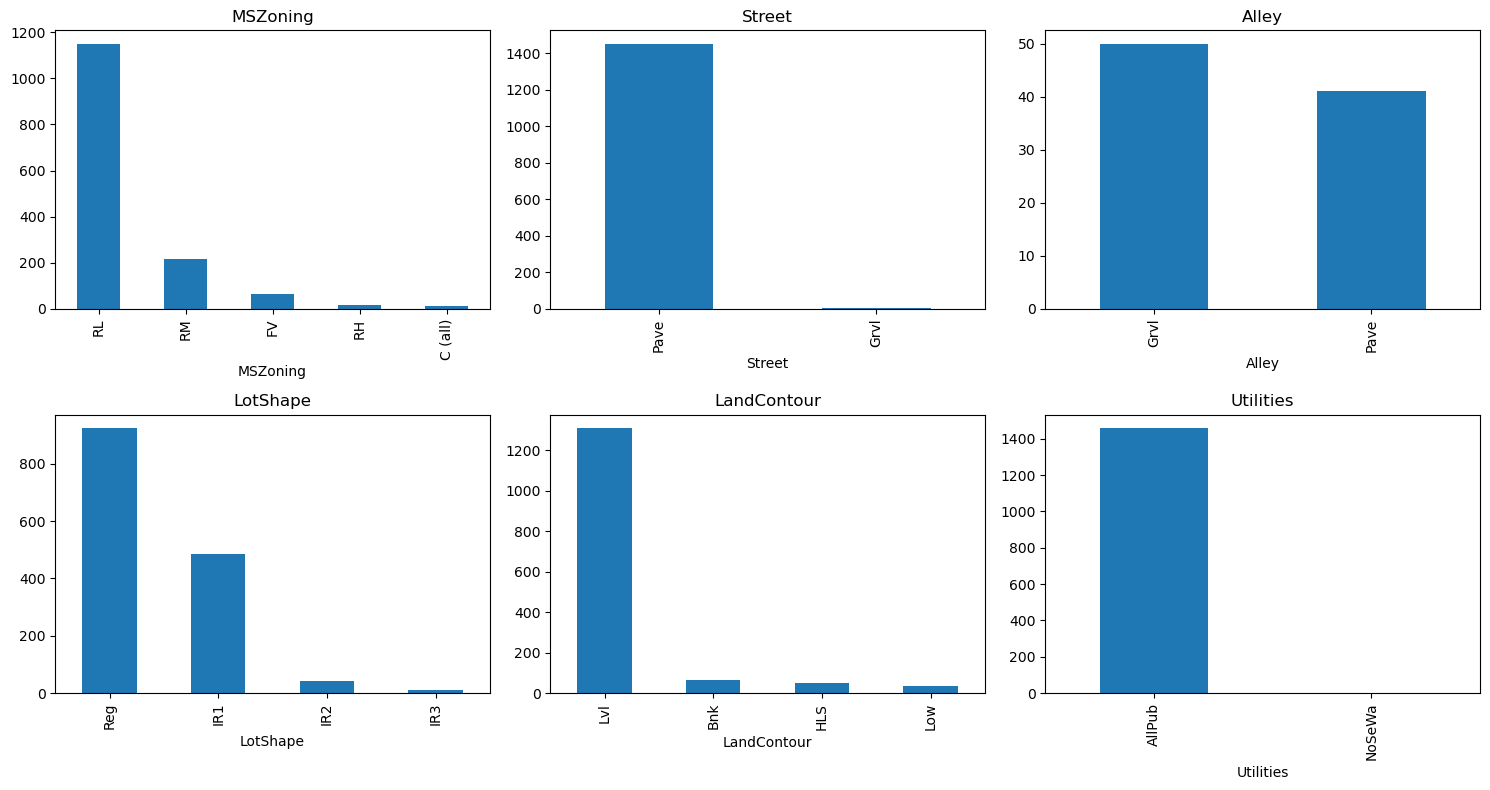

In [11]:
cat_cols = train.select_dtypes(include=["object"]).columns
fig, axes = plt.subplots(2, 3, figsize=(15,8))
for col, ax in zip(cat_cols[:6], axes.flatten()):
    train[col].value_counts().plot(kind="bar", ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

Матрица корреляций 

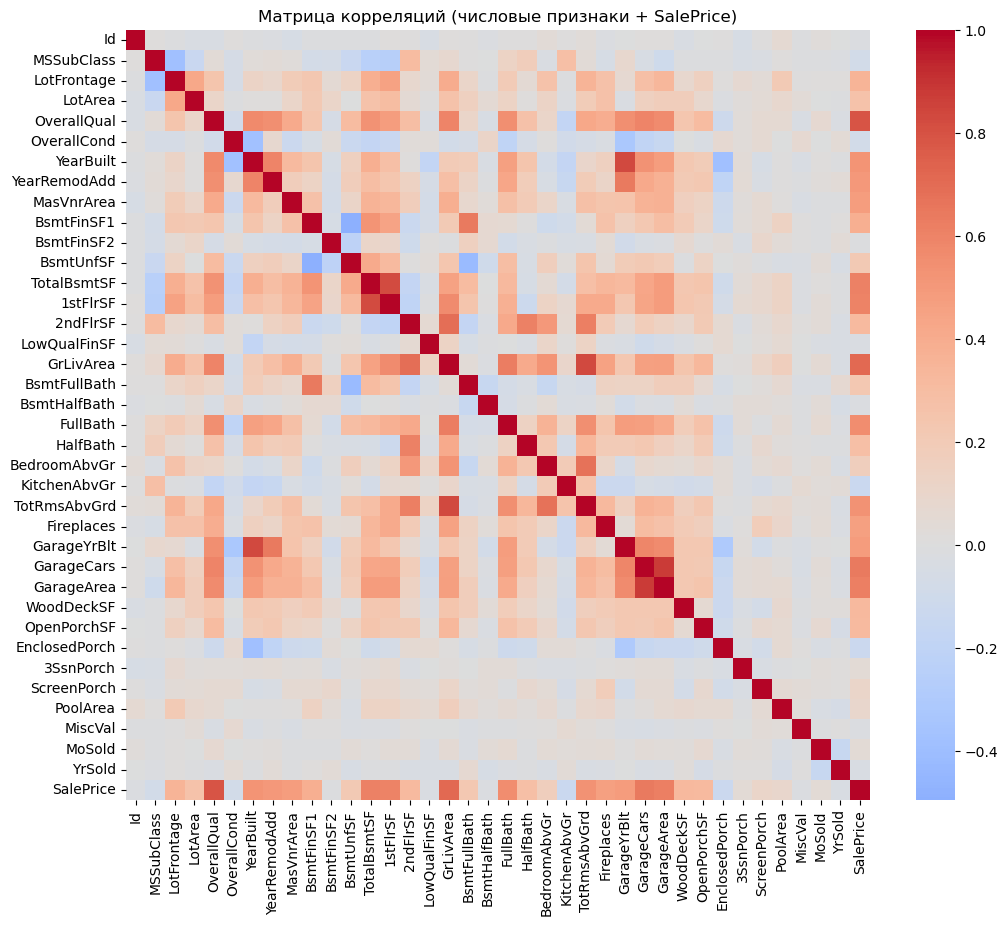

In [13]:
corr = train[num_cols.tolist() + ["SalePrice"]].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Матрица корреляций (числовые признаки + SalePrice)")
plt.show()

In [ ]:

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_log_error, make_scorer

X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Будут нужны RMLSE
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1168, 80), (292, 80), (1168,), (292,))

In [45]:
from sklearn.preprocessing import StandardScaler

num_cols = X_train.select_dtypes(include='number').columns.tolist()
cat_cols = X_train.select_dtypes(exclude='number').columns.tolist()



num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="None")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)






In [46]:
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor


#base_estimator = Ridge(alpha=1.0, random_state=42) 

cb = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=10,
    eval_metric='RMSE',
    random_state=42,
    verbose=0
)

model = Pipeline([
    ('prep', preprocessor),
    ('est', cb)
])



model.fit(X_train, y_train_log)
y_valid_log_pred = model.predict(X_valid)
rmlse_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))

print(rmlse_valid)


0.12934457357495513
